## CIFAR-10データの学習

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Using TensorFlow backend.
/Users/hidehiro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


170500096/170498071 [==============================] - 3384s  
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [2]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

/Users/hidehiro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


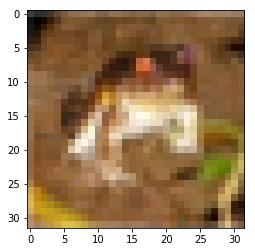

In [3]:
plt.imshow(toimage(X_train[0]))
plt.show()

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [5]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
history = model.fit(X_train, y_train, epochs=1)

Epoch 1/1
50000/50000 [==============================] - 149s 3ms/step - loss: 14.5078 - acc: 0.0999


In [7]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 9s 933us/step


[14.506285684204101, 0.10000000000000001]

## 転移学習

すでに学習済みのモデルを利用して、新しい画像の分類を行う。

Kerasでは、

単に学習済みのものを用いて分類させるだけであれば、以下のようにできる。ただしimagenetにある画像を用いて学習しており、教師データにない画像は判別できない。

In [15]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)
img = image.load_img("./image/apple2.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(preprocess_input(x))
results = decode_predictions(preds, top=5)[0]
for result in results:
    print(result)

553467904/553467096 [==============================] - 2051s 4us/step


FileNotFoundError: [Errno 2] No such file or directory: './image/apple2.jpg'

この学習済みモデルを利用して、一部分のパラメータを再学習させることにより画像の分類を行うことができる。このような手法を転移学習とかFine tuningなどという。

In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

`include_top=False`とすることで、最後の全結合から分類の層を除いたモデルを作ることができる。

In [3]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

input_tensor = Input(shape=(32, 32, 3))

model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

各層ごとにパラメータを学習させるかさせないかを設定できる。ここでは畳み込み層は全て学習しないことにしてみる。

In [4]:
for layer in model.layers:
    layer.trainable = False
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [5]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(10, activation='softmax'))
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________


In [6]:
new_model = Sequential()
for l in model.layers:
    new_model.add(l)

new_model.add(top_model)

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [7]:
new_model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

In [8]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

history = new_model.fit(X_train, y_train, validation_split=0.1, epochs=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 1449s 32ms/step - loss: 10.8011 - acc: 0.3140 - val_loss: 10.3268 - val_acc: 0.3498


In [13]:
y_test = to_categorical(y_test)
new_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 291s 29ms/step


[10.33102604675293, 0.34899999999999998]

### 演習

fasion MNISTやCIFAR100で同様の学習を行ってみよう

## Data augumentation

入手できるデータが少数の場合などに、取り込んだ画像から類似の画像を生成して、学習データを増やすことができる。

また過学習に対処することができる。
- ネットワークを単純にする
- データを増やす。

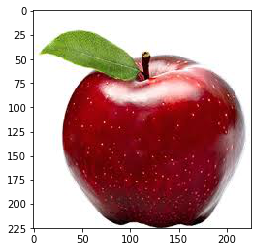

In [11]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
img = load_img("./image/apple1.jpg")
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [12]:
import numpy as np
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 225, 225, 3)

In [13]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='image', save_prefix='apple', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

data augumentationを用いて学習データを生成する。

In [25]:
# https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os
import pickle
import numpy as np

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Load label names to use in prediction results
label_list_path = 'datasets/cifar-10-batches-py/batches.meta'


keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

print('Model Accuracy = %.2f' % (evaluation[1]))

predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['label_names'][np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/10
1562/1562 [==============================] - 428s 274ms/step - loss: 1.8884 - acc: 0.3032 - val_loss: 1.5746 - val_acc: 0.4429
Epoch 2/10
1562/1562 [==============================] - 445s 285ms/step - loss: 1.5866 - acc: 0.4196 - val_loss: 1.3967 - val_acc: 0.4935
Epoch 3/10
1562/1562 [==============================] - 437s 279ms/step - loss: 1.4587 - acc: 0.4714 - val_loss: 1.2964 - val_acc: 0.5319
Epoch 4/10
1562/1562 [==============================] - 436s 279ms/step - loss: 1.3757 - acc: 0.5057 - val_loss: 1.2071 - val_acc: 0.5771
Epoch 5/10
1562/1562 [==============================] - 434s 278ms/step - loss: 1.3001 - acc: 0.5326 - val_loss: 1.1598 - val_acc: 0.5864
Epoch 6/10
1562/1562 [==============================] - 435s 278ms/step - loss: 1.2350 - acc: 0.5608 - val_loss: 1.1046 - val_acc: 0.6122
Epoch 7/10
1562/1562 [==============================] - 431s 276

## 画像の分類

ここでは自分で取り込んだ画像の分類を行なってみる。

In [14]:
from keras import backend as K
K.backend(), K.image_dim_ordering()

from keras.preprocessing.image import load_img, img_to_array
img = []
label = []
for d in ['apple','tomato','melon']:
    for n in range(20):
        img.append(img_to_array(load_img("./image/%s%s.jpg" % (d,n+1),
                                         target_size=(100,100)))/255)
        label.append(d)
        
import numpy as np
X_total = np.array(img)
X = np.concatenate((X_total[:20,],X_total[20:40,]))
y = np.array([0]*20+[1]*20)
X.shape

FileNotFoundError: [Errno 2] No such file or directory: './image/apple2.jpg'

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [30]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
28/28 [==============================] - 3s 89ms/step - loss: 1.0325 - acc: 0.4643
Epoch 2/10
28/28 [==============================] - 2s 85ms/step - loss: 0.7544 - acc: 0.4643
Epoch 3/10
28/28 [==============================] - 2s 72ms/step - loss: 0.6745 - acc: 0.6786
Epoch 4/10
28/28 [==============================] - 2s 79ms/step - loss: 0.6878 - acc: 0.5357
Epoch 5/10
28/28 [==============================] - 2s 75ms/step - loss: 0.6876 - acc: 0.5357
Epoch 6/10
28/28 [==============================] - 2s 78ms/step - loss: 0.6916 - acc: 0.5357
Epoch 7/10
28/28 [==============================] - 2s 81ms/step - loss: 0.6778 - acc: 0.5357
Epoch 8/10
28/28 [==============================] - 2s 80ms/step - loss: 0.6829 - acc: 0.5357
Epoch 9/10
28/28 [==============================] - 2s 69ms/step - loss: 0.6685 - acc: 0.5357
Epoch 10/10
28/28 [==============================] - 2s 67ms/step - loss: 0.6705 - acc: 0.5357


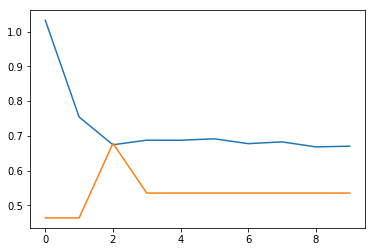

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history

loss_values = history_dict['loss']
acc_values = history_dict['acc']

plt.plot(loss_values)
plt.plot(acc_values)

In [32]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 23ms/step


[0.71602672338485718, 0.4166666567325592]

In [36]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

epochs = 20
batch_size = 3

    # Fit the model on the batches generated by datagen.flow().
history = model2.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs)

Epoch 1/20
9/9 [==============================] - 3s 329ms/step - loss: 0.7810 - acc: 0.5893
Epoch 2/20
9/9 [==============================] - 3s 315ms/step - loss: 0.7054 - acc: 0.5227
Epoch 3/20
9/9 [==============================] - 3s 317ms/step - loss: 0.6636 - acc: 0.5600
Epoch 4/20
9/9 [==============================] - 3s 329ms/step - loss: 0.5911 - acc: 0.6667
Epoch 5/20
9/9 [==============================] - 3s 314ms/step - loss: 0.6006 - acc: 0.5227
Epoch 6/20
9/9 [==============================] - 3s 319ms/step - loss: 0.4892 - acc: 0.7760
Epoch 7/20
9/9 [==============================] - 3s 315ms/step - loss: 0.6187 - acc: 0.6696
Epoch 8/20
9/9 [==============================] - 3s 332ms/step - loss: 0.3728 - acc: 0.8519
Epoch 9/20
9/9 [==============================] - 3s 326ms/step - loss: 0.3819 - acc: 0.7449
Epoch 10/20
9/9 [==============================] - 3s 329ms/step - loss: 0.2128 - acc: 0.9630
Epoch 11/20
9/9 [==============================] - 3s 317ms/step - lo

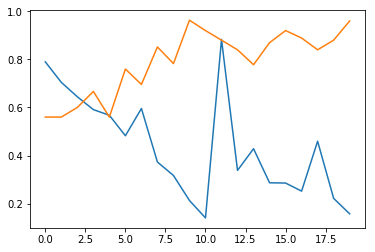

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history

loss_values = history_dict['loss']
acc_values = history_dict['acc']

plt.plot(loss_values)
plt.plot(acc_values)

In [40]:
model2.evaluate_generator(datagen.flow(X_test, y_test,
                                 batch_size=batch_size))

[0.50666838511824608, 0.8333333358168602]